# Download SDSS data

This notebook performs a lot of things in order to download, prepare and select SDSS galaxies for applying the trained CNN models to.

- import VESPA catalogue data in to a pandas dataframe
- import MPA catalogue info in to a pandas dataframe
- join the VESPA and MPA catalogues
- performa load of corrections to magnitudes and derived properties
- download SDSS spectra for each index in the dataframe

In [1]:
import pickle as pcl
import os
import sys

import numpy as np
import pandas as pd
from astropy.io import fits

from scipy.stats import binned_statistic_2d

import astropy.units as u
from astropy.cosmology import Planck13 as cosmo

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=False)
import matplotlib as mpl

from predict import predict
import extinction

Using TensorFlow backend.


In [2]:
R_V = 3.2

## VESPA

Get VESPA data (see [here](http://www-wfau.roe.ac.uk/vespa/dbaccess.html)) and apply stellar mass correction (see [here](http://www-wfau.roe.ac.uk/vespa/FAQ.html)).

In [5]:
binprop = pd.read_csv('data/VESPA/BinProp.csv')
galprop = pd.read_csv('data/VESPA/GalProp.csv')
dustprop = pd.read_csv('data/VESPA/DustProp.csv')
hrbinprop = pd.read_csv('data/VESPA/HRBinProp.csv')

binid = pd.read_csv('data/VESPA/binId.csv')
lookup = pd.read_csv('data/VESPA/lookup.csv')

galprop['M_stellar'] = 10**(np.log10(galprop['M_stellar']) - 0.14)
hrbinprop['mass'] = 10**(np.log10(hrbinprop['mass']) - 0.14)

/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Joins

In [6]:
vespa = pd.merge(left=hrbinprop, right=lookup, left_on='#index', right_on='indexP')
vespa = pd.merge(left=vespa, right=galprop, left_on='#index', right_on='#index')
vespa = pd.merge(left=vespa, right=binid, left_on='binID', right_on='binID')

dust values

In [7]:
vespa = pd.merge(left=vespa, right=dustprop[['#index','dustVal']][dustprop['dustID'] == 1], on='#index')
vespa = vespa.rename(columns={'dustVal': 'dustVal_1'})

vespa = pd.merge(left=vespa, right=dustprop[['#index','dustVal']][dustprop['dustID'] == 2], on='#index')
vespa = vespa.rename(columns={'dustVal': 'dustVal_2'})

convert bin mass to SFR

In [8]:
vespa['sfr'] = vespa['mass'] / (vespa['width'] * 1e9)

In [9]:
vespa.columns

Index(['#index', 'binID', 'runID_x', 'mass', 'mass_error', 'Z', 'Z_error',
       'indexP', 'mjd', 'plate', 'fiberID', 'specobjid', 'runID_y',
       'M_stellar', 'M_stellar_error', 't_LB', 'chi^2', 'SNR', 'Nbins',
       'Npops', 'redshift', 'ageStart', 'ageEnd', 'width', 'widthBin',
       'dustVal_1', 'dustVal_2', 'sfr'],
      dtype='object')

## MPA-JHU

get MPA-JHU tables on galaxy info (`gal_info`, see [here](https://wwwmpa.mpa-garching.mpg.de/SDSS/DR7/SDSS_info.html)), fibre and total masses, fibre SFRs, and $K$-corrected magnitudes (see [here](https://wwwmpa.mpa-garching.mpg.de/SDSS/DR7/) and [here](http://home.strw.leidenuniv.nl/~jarle/SDSS/)).

In [11]:
hdu_fibre_masses = fits.open('data/fiblgm_dr7_v5_2.fit')
hdu_total_masses = fits.open('data/totlgm_dr7_v5_2.fit')

hdu_metallicities = fits.open('data/gal_fiboh_dr7_v5_2.fits')

hdu_kcorr = fits.open('data/gal_kcorrect_dr7_v5_2.fits')
hdu_specmag = fits.open('data/gal_specmag_dr7_v5_2.fit')

hdu_info = fits.open('data/gal_info_dr7_v5_2.fit') 
hdu_fibre_sfr = fits.open('data/gal_fibsfr_dr7_v5_2.fits')

Use median values of mass, SFR, and lookup columns. Also load the absolute magnitudes as measured through the Petrosian aperture, raw from the fibre, and inferred from the SED model fitting.

In [12]:
# ids
plateid = hdu_info[1].data.field('PLATEID')
mjd = hdu_info[1].data.field('MJD')
fiberid = hdu_info[1].data.field('FIBERID')

# stellar masses and SFRs
mass_fibre = hdu_fibre_masses[1].data.field('MEDIAN')  # median
mass_total = hdu_total_masses[1].data.field('MEDIAN')  # median
sfr = hdu_fibre_sfr[1].data.field('MEDIAN')

# redshifts
z = hdu_info[1].data['z']
z_warn = hdu_info[1].data['z_warning']
sn_median = hdu_info[1].data['sn_median']

# galactic reddening
E_BV_SFD = hdu_info[1].data.field('E_BV_SFD')

## apparent magnitudes
g_mag = hdu_info[1].data.field('spectro_mag')[:,0]
r_mag = hdu_info[1].data.field('spectro_mag')[:,1]
i_mag = hdu_info[1].data.field('spectro_mag')[:,2]

g_mag_kcorr = hdu_info[1].data.field('kcor_mag')[:,0]
r_mag_kcorr = hdu_info[1].data.field('kcor_mag')[:,1]
i_mag_kcorr = hdu_info[1].data.field('kcor_mag')[:,2]

g_mag_spec = hdu_specmag[1].data.field('SPECTRO_MAG')[:,0]
r_mag_spec = hdu_specmag[1].data.field('SPECTRO_MAG')[:,1]
i_mag_spec = hdu_specmag[1].data.field('SPECTRO_MAG')[:,2]

# Absolute Magnitudes
G_mag = hdu_kcorr[1].data.field('PETRO_ABSMAG')[:,1]
R_mag = hdu_kcorr[1].data.field('PETRO_ABSMAG')[:,2]
I_mag = hdu_kcorr[1].data.field('PETRO_ABSMAG')[:,3]
Z_mag = hdu_kcorr[1].data.field('PETRO_ABSMAG')[:,4]

G_mag_fib = hdu_kcorr[1].data.field('FIBER_ABSMAG')[:,1]
R_mag_fib = hdu_kcorr[1].data.field('FIBER_ABSMAG')[:,2]
I_mag_fib = hdu_kcorr[1].data.field('FIBER_ABSMAG')[:,3]
Z_mag_fib = hdu_kcorr[1].data.field('FIBER_ABSMAG')[:,4]

G_mag_mod = hdu_kcorr[1].data.field('MODEL_ABSMAG')[:,1]
R_mag_mod = hdu_kcorr[1].data.field('MODEL_ABSMAG')[:,2]
I_mag_mod = hdu_kcorr[1].data.field('MODEL_ABSMAG')[:,3]

Create `mpa` dataframe

In [13]:
mpa = pd.DataFrame(np.array([plateid,mjd,fiberid,E_BV_SFD,
                             mass_fibre,mass_total,sfr,
                             g_mag,r_mag,i_mag,
                             g_mag_spec,r_mag_spec,i_mag_spec,
                             g_mag_kcorr,r_mag_kcorr,i_mag_kcorr,
                             G_mag,R_mag,I_mag,Z_mag,
                             G_mag_fib,R_mag_fib,I_mag_fib,Z_mag_fib,
                             G_mag_mod,R_mag_mod,I_mag_mod,
                             z,z_warn,sn_median]).T,
                   columns=['plateid','mjd','fiberid','E_BV_SFD',
                            'mpa_mass','mpa_mass_total','mpa_sfr',
                            'g_mag','r_mag','i_mag',
                            'g_mag_spec','r_mag_spec','i_mag_spec',
                            'g_mag_kcorr','r_mag_kcorr','i_mag_kcorr',
                            'G_mag','R_mag','I_mag','Z_mag',
                            'G_mag_fib','R_mag_fib','I_mag_fib','Z_mag_fib',
                            'G_mag_mod','R_mag_mod','I_mag_mod',
                            'z','z_warn','sn_median'])


Join with VESPA catalogues

In [14]:
mpa = pd.merge(left=lookup, right=mpa, left_on=['plate','mjd','fiberID'], 
                      right_on=['plateid','mjd','fiberid'], suffixes=('','_mpa'))

In [15]:
mpa['#index'] = mpa['indexP']  # avoid creating lots of overlapping indexes

mpa = pd.merge(left=mpa, right=galprop, left_on='#index', right_on='#index', copy=False)

Correct Kroupa -> Chabrier IMF

In [16]:
mpa['mpa_sfr'] -= 0.025
mpa['mpa_mass'] -= 0.025
mpa['mpa_mass_total'] -= 0.025

In [17]:
mpa['luminosity_dist'] = cosmo.luminosity_distance(mpa['redshift']).to(u.pc).value
mpa['DM'] = 5 * np.log10(mpa['luminosity_dist'] / 10)

Correct mass (already converted to SFR) from total back to fiber (see section 4.1 of Tojeiro+09, equation 22) using $z$-band magnitude

In [18]:
mpa['mass_correction'] = 1 / 10**(0.4 * np.abs(mpa['Z_mag_fib'] - mpa['Z_mag']))

Remove entries without a fiber magnitude measurement

In [19]:
fib_mask = ~np.isnan(mpa['G_mag_fib']) & ~np.isnan(mpa['R_mag_fib'])
mpa = mpa[fib_mask]

Spectra correction, from mean of magnitude difference in *g,r* bands

In [20]:
diff = np.mean([np.abs(mpa['G_mag'] - mpa['G_mag_fib']), np.abs(mpa['R_mag'] - mpa['R_mag_fib'])], axis=0)
mpa['spectra_correction'] = 2.512**diff

diff = mpa['G_mag_fib'] - mpa['G_mag']
mpa['spectra_correction_G'] = 2.512**diff

diff = mpa['R_mag_fib'] - mpa['R_mag']
mpa['spectra_correction_R'] = 2.512**diff

In [21]:
np.median(mpa['spectra_correction'][(mpa['z'] < 0.11) & (mpa['z'] > 0.09)])

4.019224634656688

Text(0, 0.5, 'R correct')

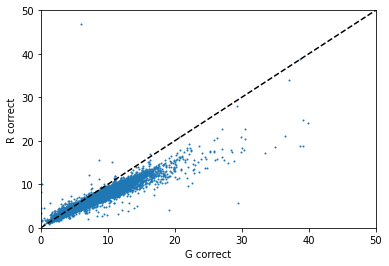

In [22]:
mask = (mpa['z'] < 0.11) & (mpa['z'] > 0.09)
plt.scatter(mpa['spectra_correction_G'][mask], mpa['spectra_correction_R'][mask], s=1)
plt.xlim(0,50)
plt.ylim(0,50)
plt.plot([0,50],[0,50],ls='dashed', color='black')
plt.xlabel('G correct')
plt.ylabel('R correct')

In [23]:
pcl.dump(mpa, open('data/mpa_df.p','wb'))
pcl.dump(vespa, open('data/vespa_df.p','wb'))
# mpa = pcl.load(open('data/mpa_df.p','rb'))